In [9]:
import pymongo
import requests
from pymongo import MongoClient
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re
import string

In [2]:
client = MongoClient()
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [3]:
# database
db = client.nytimes
# collection
articles = db.articles

In [4]:
articles.count_documents({})

0

In [5]:
# get January through May 2021 articles
url_base = 'https://api.nytimes.com/svc/archive/v1/2021/'
months = list(range(1,6))
api_key = '.json?api-key=S2XvO3Wv7bMKJqcB9b4RsaDzFuA646GA'

In [7]:
# first addition to database
for month in months:
    url = url_base + str(month) + api_key
    response = requests.get(url).json()
    data = response['response']
    for item in data['docs']:
        del item['_id']
        articles.insert_one(item)

In [8]:
articles.count_documents({})

24904

In [9]:
# add 2020 articles to database
months_2020 = list(range(1,13))
url_base_2020 = 'https://api.nytimes.com/svc/archive/v1/2020/'
for month in months_2020:
    url2 = url_base_2020 + str(month) + api_key
    response2 = requests.get(url2).json()
    data2 = response2['response']
    for item in data2['docs']:
        del item['_id']
        articles.insert_one(item)

In [10]:
articles.count_documents({})

80397

In [11]:
# add 2019 articles to database
months_2019 = list(range(1,13))
url_base_2019 = 'https://api.nytimes.com/svc/archive/v1/2019/'
for month in months_2019:
    url3 = url_base_2019 + str(month) + api_key
    response3 = requests.get(url3).json()
    data3 = response3['response']
    for item in data3['docs']:
        del item['_id']
        articles.insert_one(item)

In [12]:
articles.count_documents({})

133655

In [71]:
list(articles.find({}))

[{'_id': ObjectId('60ca7a5fd19c8809f2f910e4'),
  'abstract': 'Reasons to be hopeful about the Biden economy.',
  'web_url': 'https://www.nytimes.com/2020/12/31/opinion/2021-economy-recovery.html',
  'snippet': 'Reasons to be hopeful about the Biden economy.',
  'lead_paragraph': 'The next few months will be hell in terms of politics, epidemiology and economics. But at some point in 2021 things will start getting better. And there’s good reason to believe that once the good news starts, the improvement in our condition will be much faster and continue much longer than many people expect.',
  'print_section': 'A',
  'print_page': '18',
  'source': 'The New York Times',
  'multimedia': [{'rank': 0,
    'subtype': 'xlarge',
    'caption': None,
    'credit': None,
    'type': 'image',
    'url': 'images/2020/12/31/opinion/31krugman1/31krugman1-articleLarge.jpg',
    'height': 393,
    'width': 600,
    'subType': 'xlarge',
    'crop_name': 'articleLarge',
    'legacy': {'xlarge': 'images/2

In [13]:
extraction = list(articles.find({}, {'_id':0, 'abstract':1, 'headline.main':1, 'section_name':1, 'pub_date':1, 'byline.original':1,
                       'type_of_material':1}))

In [14]:
len(extraction)

133655

In [15]:
extraction

[{'abstract': 'Reasons to be hopeful about the Biden economy.',
  'headline': {'main': 'Things Will Get Better. Seriously.'},
  'pub_date': '2021-01-01T00:00:09+0000',
  'section_name': 'Opinion',
  'byline': {'original': 'By Paul Krugman'},
  'type_of_material': 'Op-Ed'},
 {'abstract': 'The video shows a man raising something to his car window before a bang is heard. An officer ducks for cover and then fires several rounds at the man.',
  'headline': {'main': 'Minneapolis Police Release Body Camera Video of Its First Killing Since George Floyd'},
  'pub_date': '2021-01-01T00:16:53+0000',
  'section_name': 'U.S.',
  'byline': {'original': 'By Nicholas Bogel-Burroughs'},
  'type_of_material': 'News'},
 {'abstract': 'Every December since 2017, Ada Rojas has guided women through the process of memorializing their New Year’s resolutions on a vision board, a collage that reflects their goals and helps keep them on track. But this time around, Ms. Rojas is not holding the workshop Good Vibes

In [16]:
type(extraction)

list

In [17]:
test = articles.find({}, {'_id':0, 'abstract':1, 'headline.main':1, 'section_name':1, 'pub_date':1, 'byline.original':1,
                       'type_of_material':1})

In [18]:
type(test)

pymongo.cursor.Cursor

In [19]:
import pandas as pd
df = pd.DataFrame(extraction)

In [20]:
df.head()

abstract  \
0     Reasons to be hopeful about the Biden economy.   
1  The video shows a man raising something to his...   
2  Every December since 2017, Ada Rojas has guide...   
3  The suit, led by Representative Louie Gohmert ...   
4  The United States recorded its 20 millionth ca...   

                                            headline  \
0     {'main': 'Things Will Get Better. Seriously.'}   
1  {'main': 'Minneapolis Police Release Body Came...   
2  {'main': 'Resolving to live a lot better than ...   
3  {'main': 'Justice Dept. Asks Judge to Toss Ele...   
4     {'main': 'The U.S. reaches 20 million cases.'}   

                   pub_date section_name  \
0  2021-01-01T00:00:09+0000      Opinion   
1  2021-01-01T00:16:53+0000         U.S.   
2  2021-01-01T00:58:19+0000         U.S.   
3  2021-01-01T01:24:55+0000         U.S.   
4  2021-01-01T01:28:22+0000        World   

                                              byline type_of_material  
0                    {'original': 'By Paul Krugman'}            Op-Ed  
1        {'original': 'By Nicholas Bogel-Burroughs'}             News  
2              {'original': 'By Concepción de León'}             News  
3  {'original': 'By Maggie Haberman and Katie Ben...             News  
4                     {'original': 'By Kate Taylor'}             News

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133655 entries, 0 to 133654
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          133655 non-null  object
 1   headline          133655 non-null  object
 2   pub_date          133655 non-null  object
 3   section_name      133655 non-null  object
 4   byline            133655 non-null  object
 5   type_of_material  133655 non-null  object
dtypes: object(6)
memory usage: 6.1+ MB


In [24]:
df.to_csv('nytimes.csv',index=False)

In [25]:
df.headline = df.headline.astype('str')

In [28]:
df.headline = df.headline.str.replace('{', '')

<ipython-input-28-903c816038bc>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.headline = df.headline.str.replace('{', '')


In [30]:
df.headline = df.headline.str.replace("'main'", "").str.replace("}", "")

<ipython-input-30-58e94896860f>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.headline = df.headline.str.replace("'main'", "").str.replace("}", "")


In [33]:
df.headline=df.headline.str.replace(':', '').str.replace('.', '')

<ipython-input-33-f04b9fc8a650>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.headline=df.headline.str.replace(':', '').str.replace('.', '')


In [34]:
df.head()

abstract  \
0     Reasons to be hopeful about the Biden economy.   
1  The video shows a man raising something to his...   
2  Every December since 2017, Ada Rojas has guide...   
3  The suit, led by Representative Louie Gohmert ...   
4  The United States recorded its 20 millionth ca...   

                                            headline  \
0                 'Things Will Get Better Seriously'   
1   'Minneapolis Police Release Body Camera Video...   
2      'Resolving to live a lot better than in 2020'   
3   'Justice Dept Asks Judge to Toss Election Law...   
4                  'The US reaches 20 million cases'   

                   pub_date section_name  \
0  2021-01-01T00:00:09+0000      Opinion   
1  2021-01-01T00:16:53+0000         U.S.   
2  2021-01-01T00:58:19+0000         U.S.   
3  2021-01-01T01:24:55+0000         U.S.   
4  2021-01-01T01:28:22+0000        World   

                                              byline type_of_material  
0                    {'original': 'By Paul Krugman'}            Op-Ed  
1        {'original': 'By Nicholas Bogel-Burroughs'}             News  
2              {'original': 'By Concepción de León'}             News  
3  {'original': 'By Maggie Haberman and Katie Ben...             News  
4                     {'original': 'By Kate Taylor'}             News

In [35]:
import datetime
df.pub_date = pd.to_datetime(df.pub_date)

In [36]:
df.pub_date.dtype

datetime64[ns, UTC]

In [40]:
df['date'] = df.pub_date.dt.date

In [41]:
df.head()

abstract  \
0     Reasons to be hopeful about the Biden economy.   
1  The video shows a man raising something to his...   
2  Every December since 2017, Ada Rojas has guide...   
3  The suit, led by Representative Louie Gohmert ...   
4  The United States recorded its 20 millionth ca...   

                                            headline  \
0                 'Things Will Get Better Seriously'   
1   'Minneapolis Police Release Body Camera Video...   
2      'Resolving to live a lot better than in 2020'   
3   'Justice Dept Asks Judge to Toss Election Law...   
4                  'The US reaches 20 million cases'   

                   pub_date section_name  \
0 2021-01-01 00:00:09+00:00      Opinion   
1 2021-01-01 00:16:53+00:00         U.S.   
2 2021-01-01 00:58:19+00:00         U.S.   
3 2021-01-01 01:24:55+00:00         U.S.   
4 2021-01-01 01:28:22+00:00        World   

                                              byline type_of_material  \
0                    {'original': 'By Paul Krugman'}            Op-Ed   
1        {'original': 'By Nicholas Bogel-Burroughs'}             News   
2              {'original': 'By Concepción de León'}             News   
3  {'original': 'By Maggie Haberman and Katie Ben...             News   
4                     {'original': 'By Kate Taylor'}             News   

         date  
0  2021-01-01  
1  2021-01-01  
2  2021-01-01  
3  2021-01-01  
4  2021-01-01

In [42]:
df = df.drop(columns='pub_date')

In [44]:
df.byline = df.byline.astype('str')

In [45]:
df.byline = df.byline.str.replace('{', '').str.replace('}', '').str.replace('By', '')

<ipython-input-45-826b1f5ae5ff>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.byline = df.byline.str.replace('{', '').str.replace('}', '').str.replace('By', '')


In [47]:
df.byline = df.byline.str.replace("'original'", "").str.replace(":","")

In [50]:
df.byline=df.byline.str.replace("'", "").str.strip()

In [61]:
df.byline.value_counts()

The New York Times                                     3229
The Learning Network                                   1309
Florence Fabricant                                      878
The Editorial Board                                     824
Deb Amlen                                               655
                                                       ... 
Rosa Chávez Yacila and Julie Turkewitz                    1
María Fernanda Pérez Arguello and Nicolás Albertoni       1
Ondrea L. Reisinger                                       1
Katy Reckdahl and Akasha Rabut                            1
Ellen Gabler, Zach Montague and Grace Ashford             1
Name: byline, Length: 20642, dtype: int64

In [60]:
import numpy as np
df = df.replace(r'^\s*$', np.nan, regex=True)

In [64]:
df.isna().sum()

abstract            0
headline            0
section_name        0
byline              0
type_of_material    0
date                0
dtype: int64

In [63]:
df = df.dropna()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116674 entries, 0 to 133654
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          116674 non-null  object
 1   headline          116674 non-null  object
 2   section_name      116674 non-null  object
 3   byline            116674 non-null  object
 4   type_of_material  116674 non-null  object
 5   date              116674 non-null  object
dtypes: object(6)
memory usage: 6.2+ MB


In [74]:
for i in df.abstract[:5]:
    print(i)
    print('')

Reasons to be hopeful about the Biden economy.

The video shows a man raising something to his car window before a bang is heard. An officer ducks for cover and then fires several rounds at the man.

Every December since 2017, Ada Rojas has guided women through the process of memorializing their New Year’s resolutions on a vision board, a collage that reflects their goals and helps keep them on track. But this time around, Ms. Rojas is not holding the workshop Good Vibes & Chill until February.

The suit, led by Representative Louie Gohmert of Texas, seeks to give the vice president the power to reject electoral votes that were cast for Joseph R. Biden Jr.

The United States recorded its 20 millionth case since the start of the coronavirus pandemic on Thursday, surpassing a grim milestone just as the prospects for getting the virus under control quickly in the new year appeared to dim.



In [75]:
df.section_name.value_counts()

U.S.                    22932
World                   12759
Opinion                 10697
Arts                     9118
Business Day             7820
Sports                   6623
New York                 5023
Books                    3851
Movies                   3340
Style                    3103
Food                     2807
Briefing                 2754
The Learning Network     2551
Technology               2141
Real Estate              2022
Health                   1793
Magazine                 1722
Well                     1718
Theater                  1634
Science                  1625
Crosswords & Games       1180
Obituaries               1176
Travel                   1122
Fashion & Style          1016
T Magazine                987
Climate                   968
Parenting                 837
The Upshot                766
Reader Center             483
Smarter Living            467
At Home                   411
Your Money                335
Times Insider             232
Podcasts  

In [76]:
df.head()

abstract  \
0     Reasons to be hopeful about the Biden economy.   
1  The video shows a man raising something to his...   
2  Every December since 2017, Ada Rojas has guide...   
3  The suit, led by Representative Louie Gohmert ...   
4  The United States recorded its 20 millionth ca...   

                                            headline section_name  \
0                 'Things Will Get Better Seriously'      Opinion   
1   'Minneapolis Police Release Body Camera Video...         U.S.   
2      'Resolving to live a lot better than in 2020'         U.S.   
3   'Justice Dept Asks Judge to Toss Election Law...         U.S.   
4                  'The US reaches 20 million cases'        World   

                             byline type_of_material        date  
0                      Paul Krugman            Op-Ed  2021-01-01  
1          Nicholas Bogel-Burroughs             News  2021-01-01  
2                Concepción de León             News  2021-01-01  
3  Maggie Haberman and Katie Benner             News  2021-01-01  
4                       Kate Taylor             News  2021-01-01

In [77]:
df.to_csv('cleaned_archive.csv',index=False)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116674 entries, 0 to 133654
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          116674 non-null  object
 1   headline          116674 non-null  object
 2   section_name      116674 non-null  object
 3   byline            116674 non-null  object
 4   type_of_material  116674 non-null  object
 5   date              116674 non-null  object
dtypes: object(6)
memory usage: 6.2+ MB


In [81]:
df.date = pd.to_datetime(df.date)
df['month'] = df.date.dt.month

In [84]:
df['year'] = df.date.dt.year

In [85]:
df.year.value_counts()

2020    49189
2019    47370
2021    20115
Name: year, dtype: int64

<AxesSubplot:xlabel='section_name', ylabel='count'>

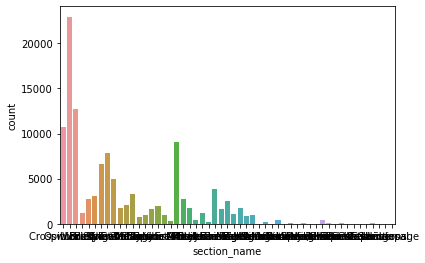

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x="section_name", data=df)


In [87]:
df.type_of_material.value_counts()

News                   87509
Op-Ed                   9291
Review                  5575
briefing                4003
Obituary (Obit)         3314
Interactive Feature     2907
Video                   2211
Editorial                920
News Analysis            371
List                     253
Schedule                 137
Slideshow                 73
Letter                    36
Biography                 30
An Appraisal              13
Question                  11
Interview                  7
Text                       4
Web Log                    4
Newsletter                 4
An Analysis                1
Name: type_of_material, dtype: int64

In [2]:
import pandas as pd
df = pd.read_csv('cleaned_archive.csv')

In [8]:
df.head()

abstract  \
0     Reasons to be hopeful about the Biden economy.   
1  The video shows a man raising something to his...   
2  Every December since 2017, Ada Rojas has guide...   
3  The suit, led by Representative Louie Gohmert ...   
4  The United States recorded its 20 millionth ca...   

                                            headline section_name  \
0                 'Things Will Get Better Seriously'      Opinion   
1   'Minneapolis Police Release Body Camera Video...         U.S.   
2      'Resolving to live a lot better than in 2020'         U.S.   
3   'Justice Dept Asks Judge to Toss Election Law...         U.S.   
4                  'The US reaches 20 million cases'        World   

                             byline type_of_material        date  
0                      Paul Krugman            Op-Ed  2021-01-01  
1          Nicholas Bogel-Burroughs             News  2021-01-01  
2                Concepción de León             News  2021-01-01  
3  Maggie Haberman and Katie Benner             News  2021-01-01  
4                       Kate Taylor             News  2021-01-01

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


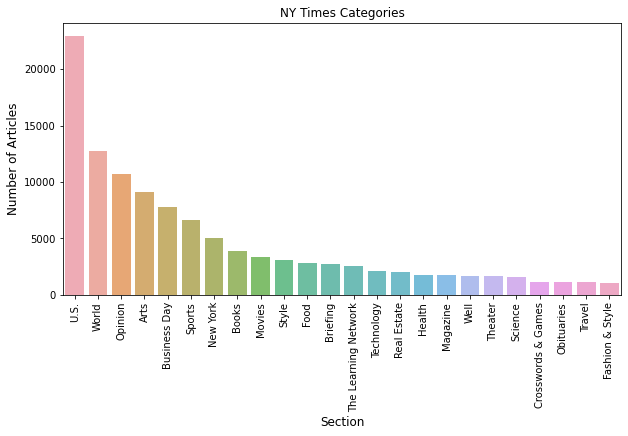

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
section_count  = df['section_name'].value_counts()[:24]
plt.figure(figsize=(10,5))
sns.barplot(section_count.index, section_count.values, alpha=0.8)
plt.title('NY Times Categories')
plt.ylabel('Number of Articles', fontsize=12)
plt.xlabel('Section', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Topic Modeling on US and World Sections

In [10]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

df['abstract'] = df.abstract.map(alphanumeric).map(punc_lower)

In [11]:
df_us = df[df['section_name'] == 'U.S.']

In [12]:
len(df_us)

22932

In [14]:
df_us.head()

abstract  \
1  the video shows a man raising something to his...   
2  every december since   ada rojas has guided wo...   
3  the suit led by representative louie gohmert o...   
6  the town of palm beach fla  imposed a   am cur...   
7  throughout the coronavirus pandemic wellattend...   

                                            headline section_name  \
1   'Minneapolis Police Release Body Camera Video...         U.S.   
2      'Resolving to live a lot better than in 2020'         U.S.   
3   'Justice Dept Asks Judge to Toss Election Law...         U.S.   
6   'The celebration at Mar-a-Lago doesn’t includ...         U.S.   
7   'Shhh! In Los Angeles, New Year’s Eve parties...         U.S.   

                             byline type_of_material        date  
1          Nicholas Bogel-Burroughs             News  2021-01-01  
2                Concepción de León             News  2021-01-01  
3  Maggie Haberman and Katie Benner             News  2021-01-01  
6                    Julia Echikson             News  2021-01-01  
7                 Evan Nicole Brown             News  2021-01-01

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['much', 'people', 'one', 'thing', 'always', 'every', 'everyone', 'yes', 'know', 'years', 'stop', 'let', 'need', 
               'someething', 'find', 'others', 'enough', 'seems', 'often', 'never', 'still', 'like', 'say', 'hope', 'small', 
               'almost', 'take', 'important', 'said', 'turned', 'making', 'like', 'also', 'need', 'get', 'way', 'got', 'came', 'would',
               'could', 'times', 'city']
stopwords.extend(newStopWords)

In [16]:
# using tfidf vectorizer 
tf = TfidfVectorizer(stop_words=stopwords)

word_matrix = tf.fit_transform(df_us['abstract'])

vocab = tf.get_feature_names()

In [17]:
len(vocab)

24059

In [18]:
# 10 topics
nmf = NMF(n_components=10)

nmf.fit(word_matrix)
topic_matrix = nmf.transform(word_matrix)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [19]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [20]:
display_topics(nmf, vocab, 10)


Topic  0
president, trump, former, donald, mr, campaign, administration, vice, impeachment, supporters

Topic  1
state, states, coronavirus, united, officials, pandemic, health, many, country, across

Topic  2
biden, joseph, jr, joe, presidentelect, vice, president, victory, mr, harris

Topic  3
county, cases, extent, outbreak, tables, detailed, map, shows, number, coronavirus

Topic  4
police, floyd, george, officer, mr, death, chauvin, former, derek, officers

Topic  5
tip, sheet, morning, mcconnell, virus, aid, mitch, biden, arrives, test

Topic  6
democratic, presidential, candidates, debate, primary, party, campaign, sanders, senator, race

Topic  7
house, white, democrats, impeachment, senate, committee, republicans, speaker, judiciary, pelosi

Topic  8
new, york, times, city, mayor, hampshire, around, jersey, cases, focused

Topic  9
court, supreme, justice, general, attorney, judge, election, department, barrett, federal


In [22]:
df_world = df[df['section_name'] == 'World']

In [23]:
len(df_world)

12759

In [24]:
df_world.head()

abstract  \
4   the united states recorded its   millionth cas...   
9   a highly contagious coronavirus variant first ...   
35  nicolas cadène sees the failings of france’s s...   
47  the afghan government and the taliban are set ...   
48  local authorities said that stones and bottles...   

                                             headline section_name  \
4                   'The US reaches 20 million cases'        World   
9    'Florida health officials detect the state’s ...        World   
35   'An Embattled Public Servant in a Fractured F...        World   
47   'What to Know as Troubled Afghan Peace Talks ...        World   
48   'France couldn’t stop the New Year’s parties ...        World   

                                    byline type_of_material        date  
4                              Kate Taylor             News  2021-01-01  
9                           Allyson Waller             News  2021-01-01  
35                             Roger Cohen             News  2021-01-01  
47  David Zucchino and Thomas Gibbons-Neff             News  2021-01-01  
48                         Constant Méheut             News  2021-01-01

In [25]:
tf = TfidfVectorizer(stop_words=stopwords)

word_matrix_world = tf.fit_transform(df_world['abstract'])

vocab_world = tf.get_feature_names()

In [26]:
len(vocab_world)

20932

In [28]:
# 10 topics
nmf_world = NMF(n_components=10)

nmf_world.fit(word_matrix_world)
topic_matrix_world = nmf_world.transform(word_matrix_world)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [29]:
display_topics(nmf_world, vocab_world, 10)


Topic  0
coronavirus, country, pandemic, world, health, cases, vaccine, first, many, virus

Topic  1
minister, prime, netanyahu, benjamin, johnson, boris, election, party, israel, trudeau

Topic  2
president, trump, administration, leader, maduro, nicolás, american, opposition, mr, biden

Topic  3
united, states, nations, iran, china, american, taliban, million, europe, sanctions

Topic  4
killed, two, least, police, officials, american, attack, forces, state, military

Topic  5
hong, kong, china, beijing, protests, police, protesters, party, chinese, mainland

Topic  6
european, union, britain, parliament, deal, brexit, british, johnson, bloc, vaccine

Topic  7
new, york, zealand, cases, law, daily, delhi, year, restrictions, mosques

Topic  8
north, korea, south, kim, korean, jongun, leader, nuclear, weapons, vietnam

Topic  9
government, public, taliban, political, afghan, critics, pressure, women, chinese, peace


In [30]:
# adding stopwords for world section
stopwords_world = nltk.corpus.stopwords.words('english')
newStopWords = ['much', 'people', 'one', 'thing', 'always', 'every', 'everyone', 'yes', 'know', 'years', 'stop', 'let', 'need', 
               'someething', 'find', 'others', 'enough', 'seems', 'often', 'never', 'still', 'like', 'say', 'hope', 'small', 
               'almost', 'take', 'important', 'said', 'turned', 'making', 'like', 'also', 'need', 'get', 'way', 'got', 'came', 'would',
               'could', 'times', 'city', 'new', 'york', 'states', 'cases', 'public', 'least', 'many']
stopwords_world.extend(newStopWords)

In [31]:
tf = TfidfVectorizer(stop_words=stopwords_world)

word_matrix_world = tf.fit_transform(df_world['abstract'])

vocab_world = tf.get_feature_names()

In [32]:
# 20 topics
nmf_world = NMF(n_components=20)

nmf_world.fit(word_matrix_world)
topic_matrix_world = nmf_world.transform(word_matrix_world)

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [33]:
display_topics(nmf_world, vocab_world, 10)


Topic  0
pandemic, health, care, workers, system, crisis, virus, officials, experts, economic

Topic  1
minister, prime, johnson, boris, netanyahu, benjamin, party, trudeau, justin, british

Topic  2
president, trump, administration, macron, emmanuel, biden, mr, putin, meeting, white

Topic  3
police, killed, protesters, officers, attack, violence, protests, security, forces, man

Topic  4
american, officials, taliban, us, afghan, peace, forces, iran, military, talks

Topic  5
european, union, britain, parliament, deal, brexit, british, bloc, johnson, withdrawal

Topic  6
hong, kong, china, beijing, chinese, protests, mainland, communist, taiwan, law

Topic  7
country, across, political, power, even, crisis, military, decades, change, long

Topic  8
government, critics, pressure, chinese, form, political, protesters, says, afghan, response

Topic  9
north, korea, south, kim, korean, jongun, nuclear, weapons, japan, vietnam

Topic  10
world, around, war, ii, leaders, countries, largest

In [41]:
df_world_covid = df_world[df_world['abstract'].str.contains("coronavirus")]
for i in df_world_covid['abstract']:
    print(i)
    print('\n')
   

the united states recorded its   millionth case since the start of the coronavirus pandemic on thursday surpassing a grim milestone just as the prospects for getting the virus under control quickly in the new year appeared to dim


a highly contagious coronavirus variant first identified in britain has been discovered in florida health officials said on thursday


the nation’s courts have reacted nimbly to the coronavirus pandemic chief justice john g roberts jr wrote in his yearend report on the state of the federal judiciary


badly hit by the coronavirus israel has distributed the first of two vaccine doses to more than   percent of its population prime minister netanyahu is leading the charge bolstering his own battered image along the way


the island’s success against the coronavirus has created a sinking feeling for many residents how much longer can their good fortune last


after days of recordsetting coronavirus tallies in tokyo the city’s governor on saturday asked japan’s c

In [42]:
df_world.head()

abstract  \
4   the united states recorded its   millionth cas...   
9   a highly contagious coronavirus variant first ...   
35  nicolas cadène sees the failings of france’s s...   
47  the afghan government and the taliban are set ...   
48  local authorities said that stones and bottles...   

                                             headline section_name  \
4                   'The US reaches 20 million cases'        World   
9    'Florida health officials detect the state’s ...        World   
35   'An Embattled Public Servant in a Fractured F...        World   
47   'What to Know as Troubled Afghan Peace Talks ...        World   
48   'France couldn’t stop the New Year’s parties ...        World   

                                    byline type_of_material        date  
4                              Kate Taylor             News  2021-01-01  
9                           Allyson Waller             News  2021-01-01  
35                             Roger Cohen             News  2021-01-01  
47  David Zucchino and Thomas Gibbons-Neff             News  2021-01-01  
48                         Constant Méheut             News  2021-01-01

In [43]:
df_us_covid = df_us[df_us['abstract'].str.contains("coronavirus")]
for i in df_us_covid['abstract']:
    print(i)
    print('\n')
   

throughout the coronavirus pandemic wellattended parties have mostly been shut down across los angeles which has led to a culture of secrecy on social media


president trump did not attend his private social club’s annual new year’s eve bash which hundreds of guests attended despite the coronavirus


los angeles county already in the throes of a devastating surge in coronavirus cases after thanksgiving travel and gatherings is being hit with a spike from christmas festivities


faced with a budget shortfall the indian health service reduced a federally funded hospital in new mexico to a clinic as coronavirus cases continued to rise in the state


an employee at a hospital in san jose wore an “airpowered” costume on christmas within days   staff members had tested positive for the coronavirus and one had died the hospital said


california’s daily coronavirus case tallies remain around four times what they were during the state’s summer surge and officials predict that the aftereffects

new coronavirus cases in the united states surpassed    on wednesday for the first time in the pandemic


thursday brought more coronavirus infections than in any other day of the pandemic around the country the virus left its mark


the coronavirus situation in the us has become catastrophically bad and continues to worsen


with joe biden leading in several important battleground states his advisers and allies have moved rapidly to discuss hiring in critical roles especially those overseeing the coronavirus response


mark meadows the white house chief of staff has contracted the coronavirus as have five other white house aides and a trump campaign adviser officials say raising fears of another outbreak sweeping through the ranks of the nation’s top officials


wilmington del — joseph r biden jr was elected president of the united states on saturday defeating president trump after campaigning on a promise to restore civility and stability to american politics and to expand the govern

In [45]:
df_us.byline.value_counts()

The New York Times                                                            722
Jill Cowan                                                                    430
Giovanni Russonello                                                           382
Adam Liptak                                                                   358
Lisa Lerer                                                                    316
                                                                             ... 
Sabrina Tavernise, Audra D. S. Burch, Sarah Mervosh and Campbell Robertson      1
Annie Karni and David E. Sanger                                                 1
Azi Paybarah and Brent Lewis                                                    1
Louis Keene and Nicholas Bogel-Burroughs                                        1
Tanner Curtis                                                                   1
Name: byline, Length: 5053, dtype: int64

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


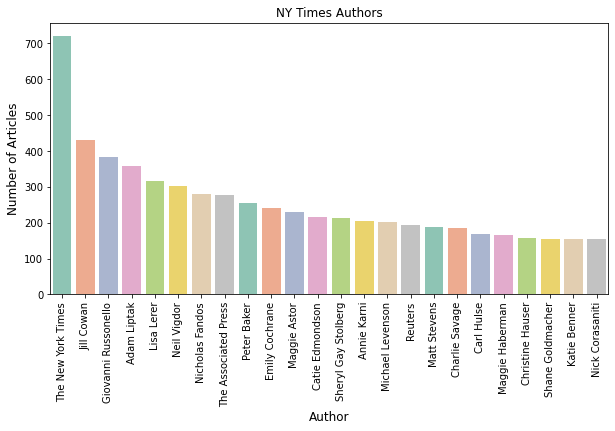

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
section_count  = df_us['byline'].value_counts()[:24]
plt.figure(figsize=(10,5))
sns.barplot(section_count.index, section_count.values, alpha=0.8, palette='Set2')
plt.title('NY Times Authors')
plt.ylabel('Number of Articles', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [46]:
df_world.byline.value_counts()

Choe Sang-Hun                                  241
Ian Austen                                     193
Megan Specia                                   185
The New York Times                             162
Stephen Castle                                 152
                                              ... 
Keith Bradsher, Mike Ives and Elaine Yu          1
José María León Cabrera and Julie Turkewitz      1
Mike Ives and Apoorva Mandavilli                 1
Choe Sang-Hun and Su-Hyun Lee                    1
Mike Ives, Tiffany May and Elaine Yu             1
Name: byline, Length: 3099, dtype: int64

C:\Users\sandy\anaconda3_2nd_download\envs\metis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


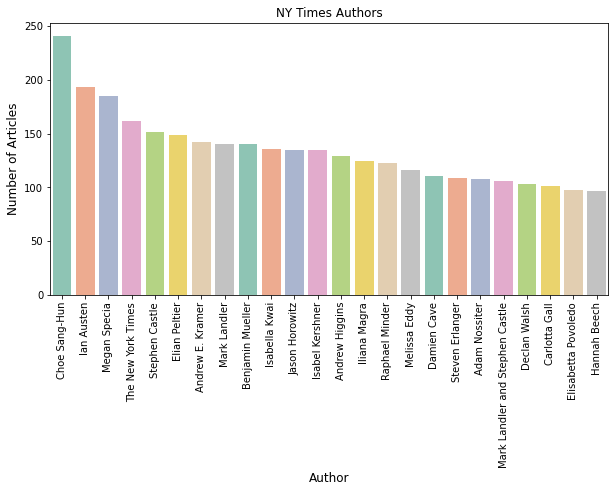

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
section_count  = df_world['byline'].value_counts()[:24]
plt.figure(figsize=(10,5))
sns.barplot(section_count.index, section_count.values, alpha=0.8, palette='Set2')
plt.title('NY Times Authors')
plt.ylabel('Number of Articles', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116674 entries, 0 to 116673
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          116674 non-null  object
 1   headline          116674 non-null  object
 2   section_name      116674 non-null  object
 3   byline            116674 non-null  object
 4   type_of_material  116674 non-null  object
 5   date              116674 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


In [51]:
df[df.duplicated(subset='abstract')]

abstract  \
241                  and what else you need to know today   
328                          here’s what you need to know   
381                  and what else you need to know today   
455     here’s what you need to know at the end of the...   
492     the democrats now appear favored to prevail in...   
...                                                   ...   
116550                       here’s what you need to know   
116571  here’s what you need to know at the end of the...   
116586                       here’s what you need to know   
116615                        heres what you need to know   
116653  recent commercial real estate transactions in ...   

                                                 headline  section_name  \
241                          'The Virus Is Still Winning'      Briefing   
328      'Britain, Trump, Coronavirus Your Tuesday Bri...      Briefing   
381                                       'Georgia Votes'      Briefing   
455      'Georgia, Electoral College, ‘Bridgerton’ You...      Briefing   
492      'Plenty of votes remain, but the Democrats no...          U.S.   
...                                                   ...           ...   
116550   'Xinjiang, 7-Eleven, Hong Kong Your Tuesday B...      Briefing   
116571   'Texas, NFL, Carlos Ghosn Your Monday Evening...      Briefing   
116586   'Carlos Ghosn, Brexit, Cyprus Your Tuesday Br...      Briefing   
116615   'Iraq, Carlos Ghosn, New Year’s Eve Your Tues...      Briefing   
116653       'Recent Commercial Real Estate Transactions'  Business Day   

                                                   byline type_of_material  \
241                                       David Leonhardt         briefing   
328                                      Victoria Shannon         briefing   
381                                       David Leonhardt         briefing   
455                 Remy Tumin and Jeremiah M. Bogert, Jr         briefing   
492                                             Nate Cohn             News   
...                                                   ...              ...   
116550                                      Melina Delkic         briefing   
116571  Andrea Kannapell, Tom Wright-Piersanti and Hir...         briefing   
116586                                          Mike Ives         briefing   
116615                                     Chris Stanford         briefing   
116653                                        Sophia June             News   

              date  
241     2021-01-04  
328     2021-01-05  
381     2021-01-05  
455     2021-01-05  
492     2021-01-06  
...            ...  
116550  2019-12-30  
116571  2019-12-30  
116586  2019-12-31  
116615  2019-12-31  
116653  2019-12-31  

[4326 rows x 6 columns]

In [52]:
df=df.drop_duplicates(subset='abstract')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112348 entries, 0 to 116673
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          112348 non-null  object
 1   headline          112348 non-null  object
 2   section_name      112348 non-null  object
 3   byline            112348 non-null  object
 4   type_of_material  112348 non-null  object
 5   date              112348 non-null  object
dtypes: object(6)
memory usage: 6.0+ MB
